In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

energy_anomaly = pd.read_csv('energy_anomaly_detection/train_features.csv')
#List all columns
print(energy_anomaly.columns)

Index(['building_id', 'timestamp', 'meter_reading', 'anomaly', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'air_temperature_mean_lag7', 'air_temperature_max_lag7',
       'air_temperature_min_lag7', 'air_temperature_std_lag7',
       'air_temperature_mean_lag73', 'air_temperature_max_lag73',
       'air_temperature_min_lag73', 'air_temperature_std_lag73', 'hour',
       'weekday', 'month', 'year', 'weekday_hour', 'hour_x', 'hour_y',
       'month_x', 'month_y', 'weekday_x', 'weekday_y', 'building_weekday_hour',
       'building_weekday', 'building_month', 'building_hour', 'building_meter',
       'is_holiday', 'gte_hour', 'gte_weekday', 'gte_month', 'gte_building_id',
       'gte_primary_use', 'gte_site_id', 'gte_meter', 'gte_meter_hour',
       'gte_meter_weekday', 'gte_meter_month', 'gte_meter_building

In [2]:
#Drop columns we arent going to use
energy_anomaly.drop(energy_anomaly.columns.difference(['meter_reading','month', "square_feet", "weekday", "hour", "anomaly"]), axis=1, inplace=True)

In [3]:
#Drop rows with NaN
energy_anomaly = energy_anomaly.dropna().reset_index(drop=True)

In [4]:
energy_anomaly.head()

,meter_reading,anomaly,square_feet,hour,weekday,month
0,175.184,1,97532,0,4,1
1,167.392,1,118338,0,4,1
2,10.275,0,32206,0,4,1
3,16.306,0,15489,0,4,1
4,117.200,0,138316,0,4,1


In [5]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split


x = energy_anomaly.drop('anomaly', axis=1)
y = energy_anomaly['anomaly']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [11]:
import sklearn
from sklearn.metrics import auc
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
#The best k is somewhere around this range (Found this through trial and error, you can try a wider range if you want to be sure)
k_values = range(111, 120)
scores2 = {}

#Try a bunch of k values
for i in tqdm(k_values):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    y_knn = knn.predict_proba(x_test)
    curve_knn = sklearn.metrics.roc_curve(y_test, y_knn[:, 1])
    score  = auc(curve_knn[0], curve_knn[1])
    scores2[i] = score


100%|██████████| 9/9 [10:25<00:00, 69.49s/it]


In [12]:
#Convert scores to tuples and sort them
print(scores2)
scores2 = [(k, v) for k, v in scores2.items()]
scores2.sort(key=lambda x: x[1], reverse=True)
k_best = scores2[0][0]
print(f"Best k: {k_best}")

{111: 0.8491814648530329, 112: 0.849463819552495, 113: 0.8494444529190983, 114: 0.8496272828638161, 115: 0.8494604683220358, 116: 0.8495017214760232, 117: 0.8496836833376471, 118: 0.849709597287571, 119: 0.8496403150856678}
Best k: 118


In [42]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=8)

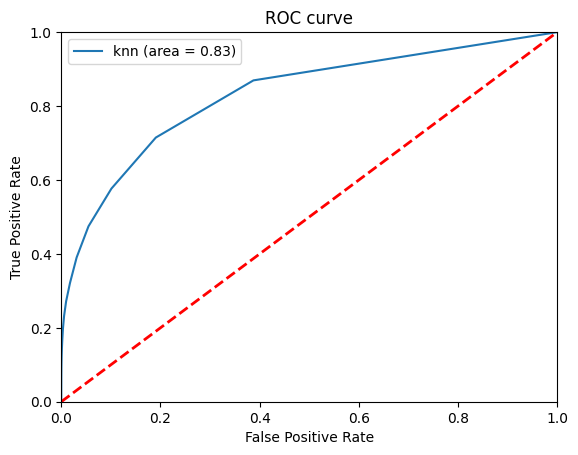

In [40]:
#From worksheet 2
import sklearn
from sklearn.metrics import roc_curve, auc
y_knn   = knn.predict_proba(x_test)

curve_knn    = sklearn.metrics.roc_curve(y_test, y_knn[:, 1])

# Compute Area Under the Curve
auc_knn    = auc(curve_knn[0], curve_knn[1])
plt.plot(curve_knn[0], curve_knn[1], label='knn (area = %0.2f)'% auc_knn)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=2)
plt.legend()


In [15]:
#Export model
import pickle
filename = 'models/knn_model.sav'
pickle.dump(knn, open(filename, 'wb'))
print("Model saved as knn_model.sav")

Model saved as knn_model.sav


In [8]:
#Load Pickle
import pickle
filename = 'models/knn_model.sav'
knn = pickle.load(open(filename, 'rb'))

<Figure size 600x600 with 0 Axes>

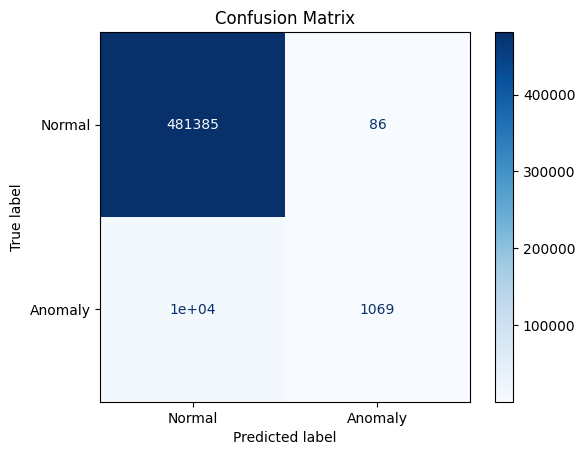

In [43]:
#cm vizualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_knn   = knn.predict_proba(x_test)
cm= confusion_matrix(y_test, y_knn[:, 1] > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()